In [597]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from metric_learn import MMC_Supervised
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, cdist
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.manifold import MDS
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import log_loss
from scipy.optimize import fsolve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from time import perf_counter
from scipy.integrate import odeint

## Distributions

### Make object oriented -> each model has its own prior, etc

In [263]:
class GaussianNoise:
    def __init__(self):
        self.model = "gaussian"
        self.metaModel = "noise"

    def generate(self, N):
        return np.random.normal(size=N)

In [272]:
class UniformNoise:
    def __init__(self):
        self.model = "uniform"
        self.metaModel = "noise"

    def generate(self, N):
        return np.random.uniform(size=N)

In [268]:
class CauchyNoise:
    def __init__(self):
        self.model = "cauchy"
        self.metaModel = "noise"

    def generate(self, N):
        return np.random.standard_cauchy(N)

In [269]:
class ExpNoise:
    def __init__(self):
        self.model = "exp"
        self.metaModel = "noise"

    def generate(self, N):
        return np.random.exponential(size=N)

In [309]:
def sampleNoise(num_samples, N=None):
    models = [GaussianNoise(), UniformNoise(), CauchyNoise(), ExpNoise()] # enumerate all noise models
    sel_model = list()
    lengths = list()
    sols = list()
    if N is not None:
        N = np.repeat(N, num_samples)
    else:
        N = np.random.randint(50, 5000, num_samples)
    for i in range(num_samples):
        model = random.choice(models)
        sel_model.append(model)
        sol = model.generate(N[i])
        sols.append(sol)
        lengths.append(len(sol))
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(len(sols))])
    df = pd.DataFrame(features)
    df['N'] = N
    df['model'] = [sel_model[i].model for i in range(len(sel_model))]
    df['metaModel'] = [sel_model[i].metaModel for i in range(len(sel_model))]
    ts = sols

    return df, ts

In [491]:
class featureSpaceOptim:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.projDataNorm = None # normalized projected data
        self.projDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.mmcfit = None # fitted mmc model
        self.optimCalDataNorm = None # optimized calibrated space
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def calibrate(self, cal_samples, cal_ts):
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.calDataNorm['metaModel'] = cal_samples['metaModel'].values

        le = LabelEncoder().fit(self.calDataNorm['model'])
        y = le.transform(self.calDataNorm['model'])
        mmc = MMC_Supervised(random_state=624)
        mmc_fit = mmc.fit(self.calDataNorm.iloc[:,:22], y)
        X_mmc = mmc_fit.transform(self.calDataNorm.iloc[:,:22])
        self.mmcfit = mmc_fit
        optimCalDataNorm = pd.DataFrame(X_mmc)
        optimCalDataNorm['N'] = self.calDataNorm['N'].values
        optimCalDataNorm['model'] = self.calDataNorm['model'].values
        optimCalDataNorm['metaModel'] = self.calDataNorm['metaModel'].values
        self.calDataNorm = optimCalDataNorm
        self.learnedMetric = mmc_fit.get_metric()
        
    def project(self, proj_samples, proj_ts): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        self.projDataNorm['metaModel'] = proj_samples['metaModel'].values

    def pcaViz(self): # generalize to other projection technqiues
        pca = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
        pca_calibrated = pca.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Optimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
    



In [578]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = None # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.calDataNorm['metaModel'] = cal_samples['metaModel'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evalaute(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['model'] = test_samples['model'].values
        self.testDataNorm['metaModel'] = test_samples['metaModel'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def project(self, proj_samples, proj_ts, showPlot=True): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        self.projDataNorm['metaModel'] = proj_samples['metaModel'].values

        if showPlot:
            pca_project = self.pca_fit.transform(self.projDataNorm.iloc[:,:22])
            pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
            plt.figure(figsize=(12,8))
            plt.title('Calibrated Space + Projected Data')
            plt.scatter(pca_project[:,0], pca_project[:,1], s=3, c='r', label='New Data')
            plt.scatter(pca_calibrated[:,0], pca_calibrated[:,1], s=3, c='b', label='Calibration Data')
            plt.show()

    def pcaViz(self): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()

    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon


In [571]:
space = featureSpace()

In [574]:
def evaluate_space(model, num_iter, showPlot=True):
    meta_acc = list()
    meta_logloss = list()
    radii = np.linspace(0.5, 2, 30)
    for i in range(num_iter):
        print(f'iteration: {i}')
        # generate calibration data 
        df_cal, ts_cal = sampleNoise(2000)
        # generate test data
        df_test, ts_test = sampleNoise(500) 
        # train the space
        model.fit(df_cal, ts_cal)
        df_eval, predicted_proba = space.evalaute(df_test, ts_test, radii)
        meta_acc.append(df_eval['accuracy'].values)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    optimal_epsilon_acc = radii[np.argmax(np.mean(meta_acc, axis=0))]
    print(f'Optimal Epsilon (Accuracy): {optimal_epsilon_acc}')
    
    if showPlot:
        fig, ax = plt.subplots(1,2, figsize=(22,8))
        ax[0].errorbar(radii, np.mean(meta_acc, axis=0), yerr=np.std(meta_acc, axis=0), label='std', capsize=3)
        ax[0].axvline(x=radii[np.argmax(np.mean(meta_acc, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[0].set_xlabel('$\epsilon$')
        ax[0].set_ylabel('Accuracy')

        ax[1].errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        ax[1].axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[1].set_xlabel('$\epsilon$')
        ax[1].set_ylabel('Log Loss')
        plt.show()
    


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
Optimal Epsilon (LogLoss): 1.4827586206896552
Optimal Epsilon (Accuracy): 1.1206896551724137


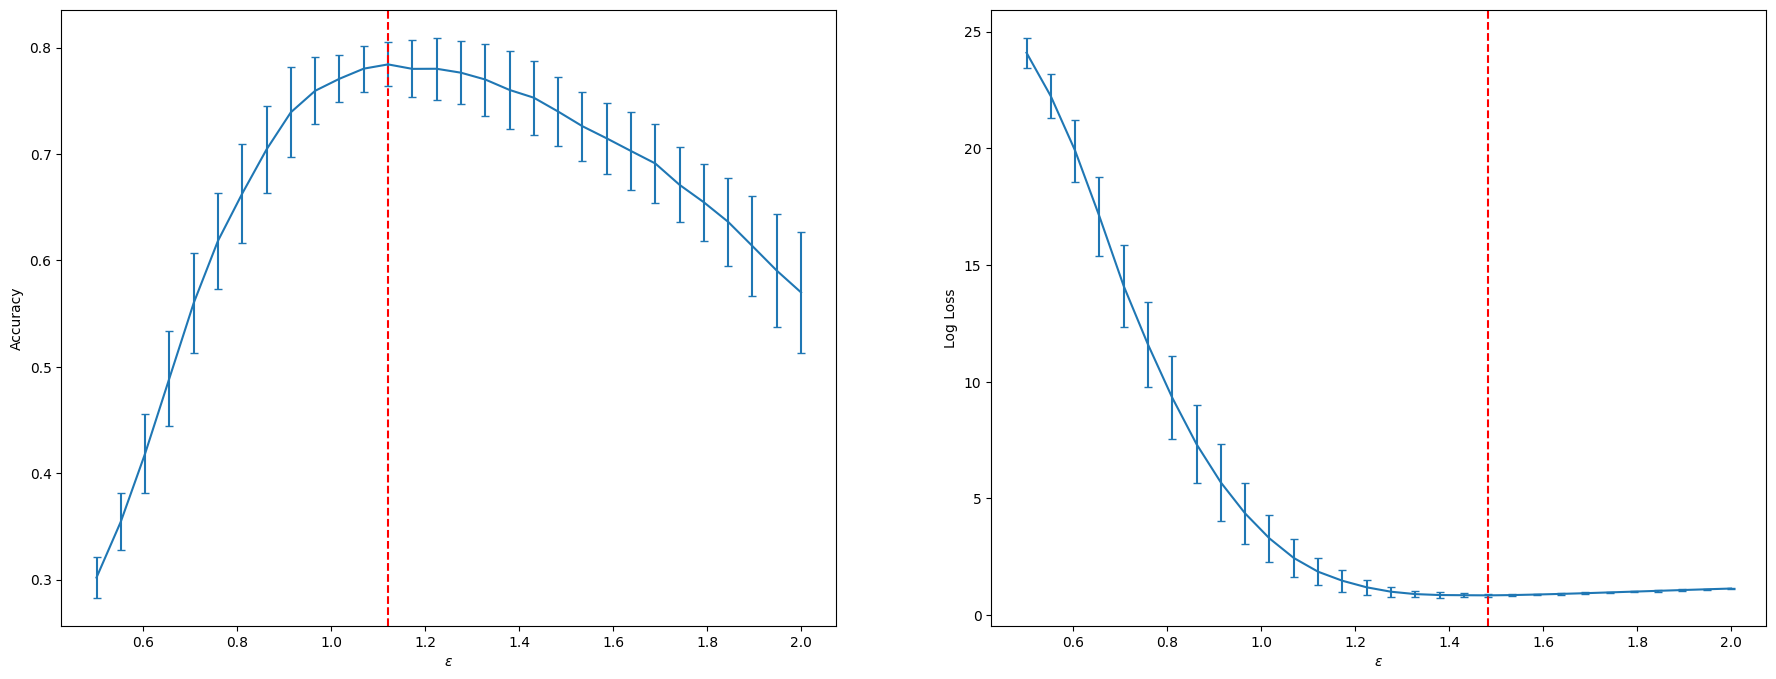

In [577]:
evaluate_space(space, 20)

In [611]:
df, ts = sampleNoise(2000)
space = featureSpace()
space.fit(df, ts)

In [613]:
test_df = space.calDataNorm

In [614]:
# define dimensionless ratio of intra/inter class median distance 
grouped = test_df.groupby('model')
intra_class_distances = list()
for name, group in grouped:
    dists = pdist(group.iloc[:,:22].values, metric='euclidean')
    intra_class_distances.append(dists)
inter_class_distances = list()
for name1, group1 in grouped:
    for name2, group2 in grouped:
        if name1 != name2:
            inter_class_dist = cdist(group1.iloc[:,:22].values, group2.iloc[:,:22].values, metric='euclidean')
            inter_class_distances.append(inter_class_dist)
            print(name1, name2, inter_class_dist.mean())

cauchy exp 1.990334524586543
cauchy gaussian 2.124304325803719
cauchy uniform 2.218261436280264
exp cauchy 1.990334524586543
exp gaussian 1.7610619958808735
exp uniform 1.8400615127903004
gaussian cauchy 2.1243043258037186
gaussian exp 1.7610619958808735
gaussian uniform 1.7181762920923738
uniform cauchy 2.218261436280264
uniform exp 1.8400615127903002
uniform gaussian 1.718176292092374


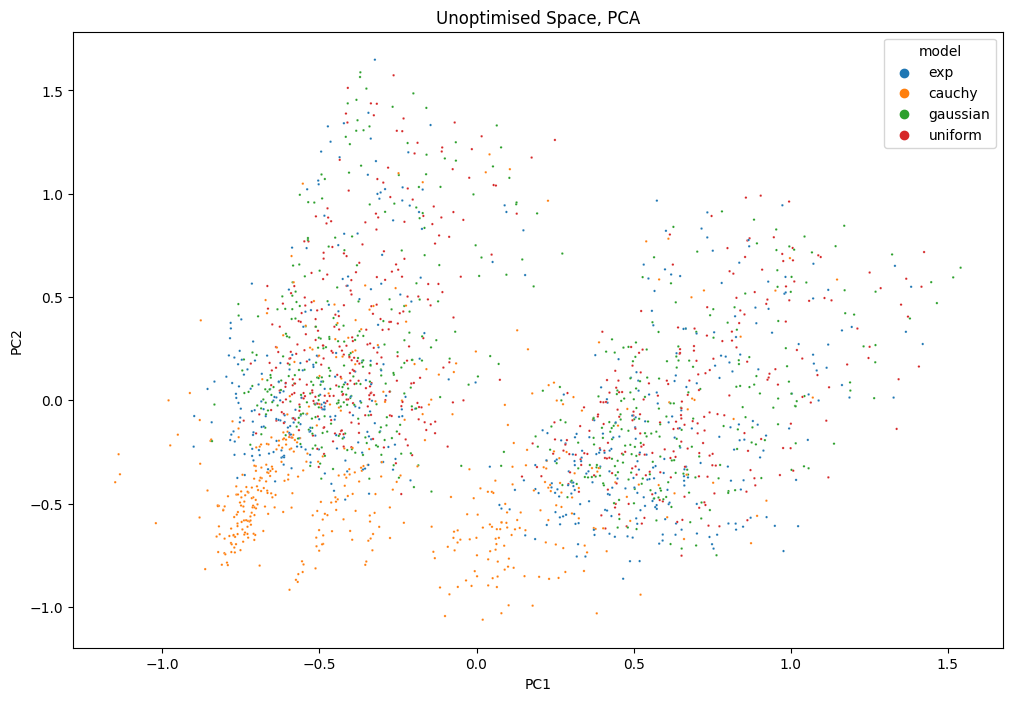

In [615]:
space.pcaViz()

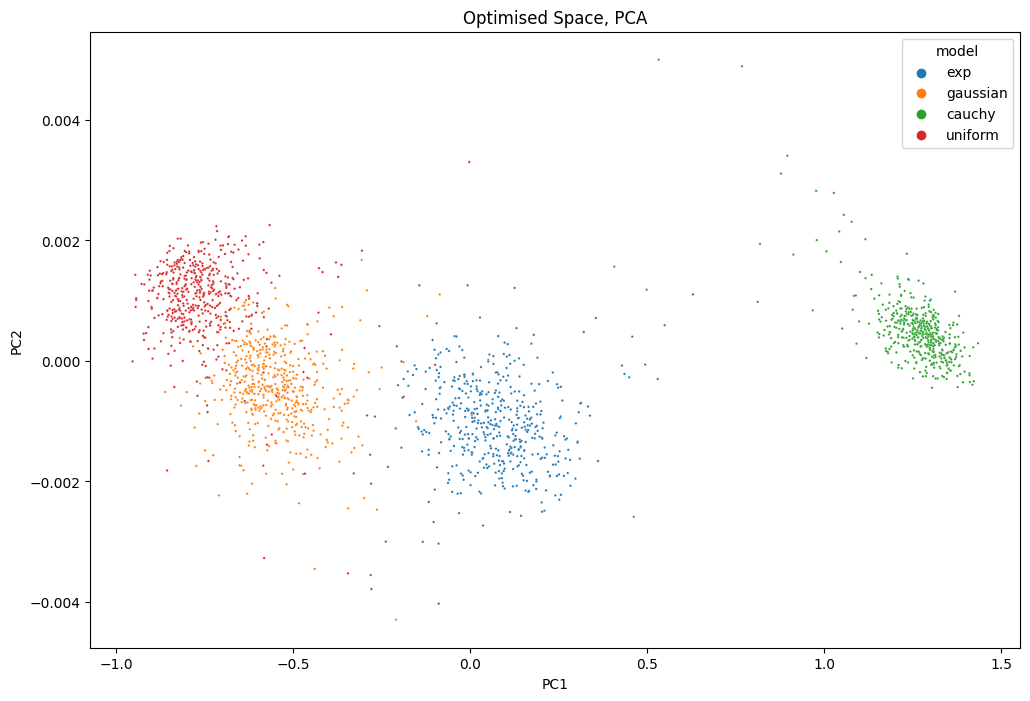

In [494]:
space_otim.pcaViz()